# Загрузка, формирование датасета

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [1]:
import torch
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from PIL import Image
import PIL.ImageOps
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
data_dir = '/content/gdrive/My Drive/lungsCT'

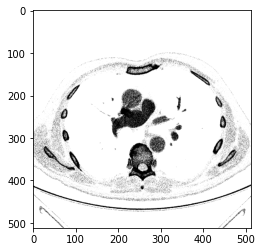

In [5]:
filename_img = data_dir + "/2d_images/ID_0000_Z_0142.tif"
input_image = Image.open(filename_img).convert("L")
# input_image = np.array(input_image).astype('float32')
# print(input.shape())
plt.imshow(PIL.ImageOps.invert(input_image), cmap="gray")
plt.show()

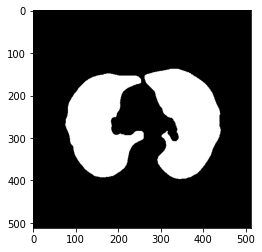

In [6]:
filename_mask = data_dir + "/2d_masks/ID_0000_Z_0142.tif"
mask = Image.open(filename_mask).convert("1")
plt.imshow(mask)
plt.show()

Класс для формирования датасета, принимающий пути к папкам с изображениями и масками

In [7]:
class segmDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        # image = np.array(Image.open(img_path).convert("L"))
        # mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        # mask[mask == 255.0] = 1.0

        if self.transform is not None:
            # augmentations = self.transform(image=image, mask=mask)
            # image = augmentations["image"]
            # mask = augmentations["mask"]
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [8]:
transform = transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                #                      std=[0.229, 0.224, 0.225]),
                                ])

In [9]:
dataset = segmDataset(data_dir+"/2d_images", data_dir+"/2d_masks", transform=transform)

In [10]:
len(dataset)

267

In [11]:
def show_2imgs(img1, img2):
  print(img1.shape, img2.shape)
  print(type(img1), type(img2))

  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.set_size_inches(9, 9)
  axes[0].set_title('img')
  axes[1].set_title('orig_mask')

  axes[0].imshow(torch.squeeze(img1), cmap='gray')
  axes[1].imshow(torch.squeeze(img2), cmap='gray')

  # plt.figure(figsize=(9, 9))
  # plt.subplot(121), plt.imshow(torch.squeeze(img1), cmap='gray') 
  # plt.subplot(122), plt.imshow(torch.squeeze(img2), cmap='gray'), plt.set_title("mask")
  plt.show()

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
<class 'torch.Tensor'> <class 'torch.Tensor'>


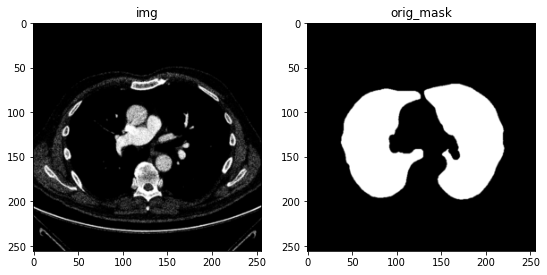

In [12]:
img, mask = dataset[0]
show_2imgs(img, mask)

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
<class 'torch.Tensor'> <class 'torch.Tensor'>


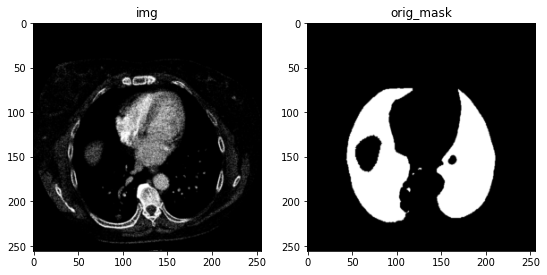

In [13]:
img, mask = dataset[137]
show_2imgs(img, mask)

# Разделение датасета на train, validation и test

In [14]:
ds_train, ds_val, ds_test = torch.utils.data.random_split(
        dataset, [203, 32, 32], generator=torch.Generator().manual_seed(42))

In [15]:
len(ds_train), len(ds_val), len(ds_test)

(203, 32, 32)

# DataLoader

In [16]:
from torch.utils.data.dataloader import DataLoader

batch_size=8

In [17]:
dl_train = DataLoader(ds_train, batch_size, num_workers=2, shuffle=True, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size, num_workers=2, pin_memory=True)

# Функции для обучения

**Dice_metric and Bce_dice_loss**

Взято от сюда: https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388

In [40]:
def dice_metric(inputs, target):
  intersection = 2.0 * (target * inputs).sum()
  union = target.sum() + inputs.sum()
  if target.sum() == 0 and inputs.sum() == 0:
    return 1.0
  return (intersection / union).cpu().item()

In [41]:
_, mask = dataset[0]
dice_metric(mask, mask)

0.986183226108551

In [59]:
def dice_loss(inputs, target):
  num = target.size(0)
  inputs = inputs.reshape(num, -1)
  target = target.reshape(num, -1)
  smooth = 1.0
  intersection = (inputs * target)
  dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
  dice = 1 - dice.sum() / num
  return dice.cpu()

In [60]:
def bce_dice_loss(inputs, target):
  dicescore = dice_loss(inputs, target)
  bcescore = nn.BCELoss()
  bceloss = bcescore(inputs, target)
  return (bceloss + dicescore).cpu()

Функции обучения и эволюции

In [51]:
# проверить качество модели на dataLoader (получить среднии loss и метрику по всем батчам)
def evaluate(model, dloader, loss_fn, score_fn, device):
    model.eval()
    with torch.no_grad():
        mean_loss = [] # сюда будем складывать средний лосс по батчам
        score_lst = []
        
        for imgs, masks in dloader:
            imgs = imgs.to(device, dtype=torch.float)
            masks = masks.to(device, dtype=torch.float)
            
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            score = score_fn(preds, masks)

            mean_loss.append(loss.cpu().numpy()) # добавляем в массив
            score_lst.append(score)
        
        return np.mean(mean_loss), np.mean(score_lst)

In [57]:
def fit(num_epochs, model, loss_fn, opt, dl_train, dl_val, score_fn, device):
    history = {'score': [], 'val_score': [], 'loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs): 
        
        # обучение
        model.train()
        for imgs, masks in dl_train: # train_dl сам перемешается и разделиться при каждой следующей эпохе
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            preds = model(imgs) # предсказываем
            loss = loss_fn(preds, masks) # вычисляем ошибку
            loss.backward() # вычисляем градиент loss_fn по весам и смещениям
            opt.step() # делаем шаг к уменьшению ошибки - обновляем веса и смещения
            opt.zero_grad() # обнуляем градиент, чтобы значения не накапливались
            
            
        # Каждые 1 эпох вывод прогресса и сохранение истории
        if (epoch+1) % 1 == 0:
            score_train = score_fn(preds, masks)
            loss_val, score_val = evaluate(model, dl_val, loss_fn, score_fn, device)
            
            # вывод статистики
            print('Epoch [{}/{}], loss: {:.4f} - score: {:.4f}, val_loss: {:.4f} - val_score: {:.4f}'
                  .format(epoch+1, num_epochs, loss, score_train, loss_val, score_val))
            
            # сохранение истории  
            history['score'].append(score_train)
            history['val_score'].append(score_val)
            history['loss'].append(loss.item())
            history['val_loss'].append(loss_val)
            
    return history

Вывод графика

In [24]:
def show_history(history):
    step = 1 # через сколько эпох выводиться статистика
    plt.plot([i for i in range(step, len(history['score'])*step+1, step)], history['score'], '-x', 
         label='Train score')
    plt.plot([i for i in range(step, len(history['val_score'])*step+1, step)], history['val_score'], '-x',
         label='Val score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Score vs. No. of epochs');
    plt.legend()
    plt.show()

# Модель и её обучение

https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/

(https://pypi.org/project/segmentation-models-pytorch/)

In [64]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [65]:
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Гипер параметры
num_epochs = 20
# batch_size = 128
learning_rate = 0.001

cuda


In [66]:
model = model.to(device)
loss_fn = bce_dice_loss
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

Посмотреть размер изображений до и после прогона через модель

In [29]:
for images, masks in dl_train:
    print('images.shape:', images.shape)
    images = images.to(device)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([8, 1, 256, 256])
out.shape: torch.Size([8, 1, 256, 256])


Посмотрим качество модели до обучения

In [67]:
loss, dice = evaluate(model, dl_val, loss_fn, dice_metric, device)
print('loss: {:.4f} - dice: {:.4f}'.format(loss, dice))

loss: 1.3960 - dice: 0.3111


Обучим и посмотрим график

In [68]:
history = fit(num_epochs, model, loss_fn, opt, dl_train, dl_val, dice_metric, device)

Epoch [1/20], loss: 0.5626 - score: 0.6640, val_loss: 1.3173 - val_score: 0.2151
Epoch [2/20], loss: 0.3455 - score: 0.7914, val_loss: 1.4961 - val_score: 0.1255
Epoch [3/20], loss: 0.2478 - score: 0.8559, val_loss: 0.2810 - val_score: 0.8311
Epoch [4/20], loss: 0.4825 - score: 0.7911, val_loss: 0.2371 - val_score: 0.8641
Epoch [5/20], loss: 0.1444 - score: 0.9233, val_loss: 0.1911 - val_score: 0.8914
Epoch [6/20], loss: 0.1737 - score: 0.8897, val_loss: 0.1662 - val_score: 0.9055
Epoch [7/20], loss: 0.0984 - score: 0.9433, val_loss: 0.1289 - val_score: 0.9274
Epoch [8/20], loss: 0.1122 - score: 0.9342, val_loss: 0.1059 - val_score: 0.9429
Epoch [9/20], loss: 0.0865 - score: 0.9543, val_loss: 0.1735 - val_score: 0.9174
Epoch [10/20], loss: 0.0803 - score: 0.9577, val_loss: 0.0965 - val_score: 0.9466
Epoch [11/20], loss: 0.0881 - score: 0.9559, val_loss: 0.0906 - val_score: 0.9527
Epoch [12/20], loss: 0.0995 - score: 0.9514, val_loss: 0.3280 - val_score: 0.8326
Epoch [13/20], loss: 0.07

In [69]:
history

{'loss': [0.5626423358917236,
  0.3455406427383423,
  0.24775879085063934,
  0.4825383424758911,
  0.1443553864955902,
  0.17365600168704987,
  0.09838370978832245,
  0.11218860745429993,
  0.08653327822685242,
  0.08029097318649292,
  0.0880524218082428,
  0.09954488277435303,
  0.07371032238006592,
  0.07466214895248413,
  0.060359299182891846,
  0.0682285726070404,
  0.09675299376249313,
  0.07117590308189392,
  0.05929878354072571,
  0.0598311573266983],
 'score': [0.6639637351036072,
  0.7914128303527832,
  0.8559187650680542,
  0.7910594940185547,
  0.923281729221344,
  0.8896903395652771,
  0.9432964324951172,
  0.9341533184051514,
  0.9542945623397827,
  0.9576887488365173,
  0.9559263586997986,
  0.9513552784919739,
  0.9602780938148499,
  0.960312008857727,
  0.966179609298706,
  0.9664939045906067,
  0.9492468237876892,
  0.9626573920249939,
  0.9684138894081116,
  0.9687705039978027],
 'val_loss': [1.3173205,
  1.4960694,
  0.28101075,
  0.2370893,
  0.19107342,
  0.1661920

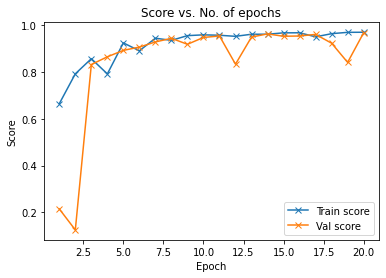

In [70]:
show_history(history)

# Тестирование

In [71]:
dl_test = DataLoader(ds_test, batch_size, num_workers=2, pin_memory=True)

In [73]:
loss, dice = evaluate(model, dl_test, loss_fn, dice_metric, device)
print('loss: {:.4f} - dice: {:.4f}'.format(loss, dice))

loss: 0.0617 - dice: 0.9688


In [112]:
# предсказание маски одного изображения
def predict_image(img, model):
    img = img.to(device)
    xb = img.unsqueeze(0)  # добавить еще одно измерение в начале тензора 1x28x28, делая его тензором 1x1x28x28, который модель рассматривает как пакет, содержащий одно изображение
    yb = model(xb)
    yb = (yb[0][0]>0.5).float()
    return yb.cpu()

In [77]:
def show_imgs(img, mask, mask_pred):
  fig, axes = plt.subplots(nrows=1, ncols=3)
  fig.set_size_inches(12, 12)
  axes[0].set_title('img')
  axes[1].set_title('orig_mask')
  axes[2].set_title('pred_mask')

  axes[0].imshow(torch.squeeze(img), cmap='gray')
  axes[1].imshow(torch.squeeze(mask), cmap='gray')
  axes[2].imshow(torch.squeeze(mask_pred), cmap='gray')
  plt.tight_layout()
  plt.show()

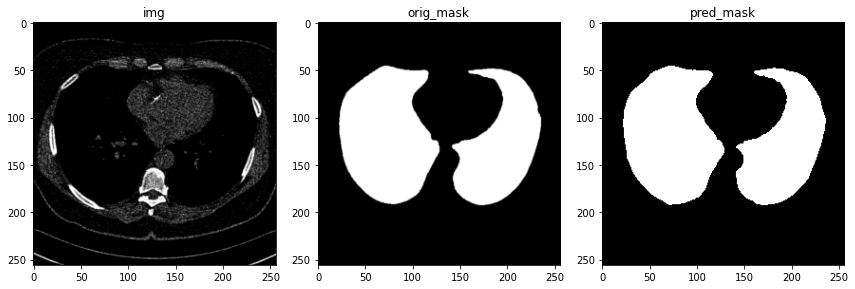

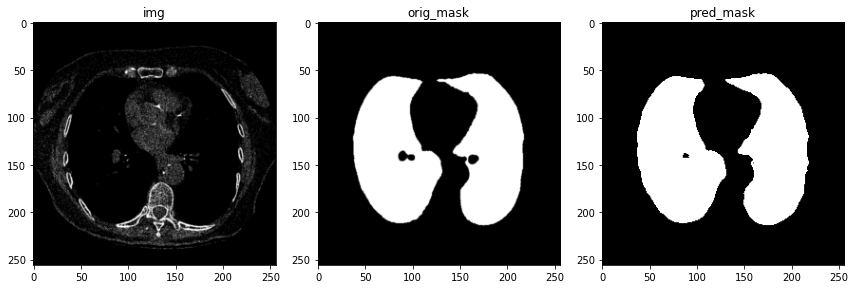

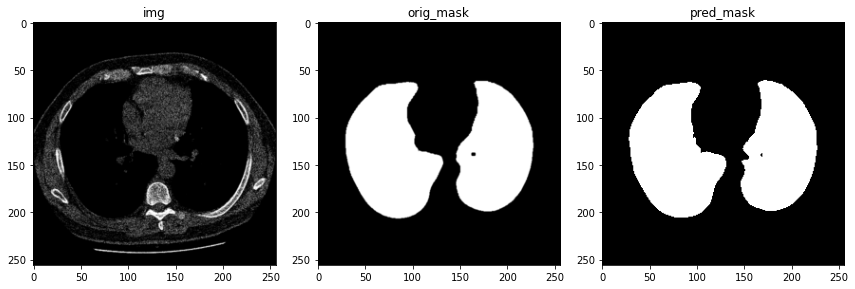

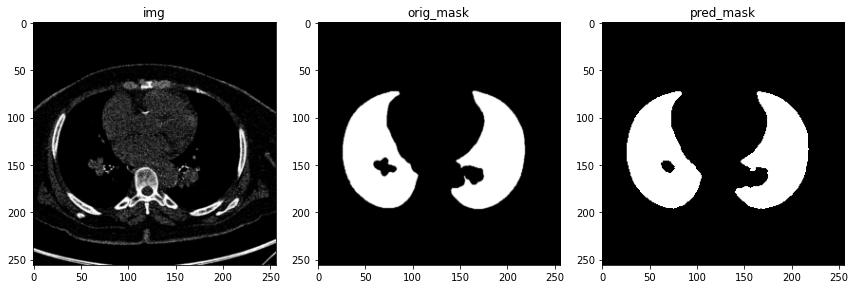

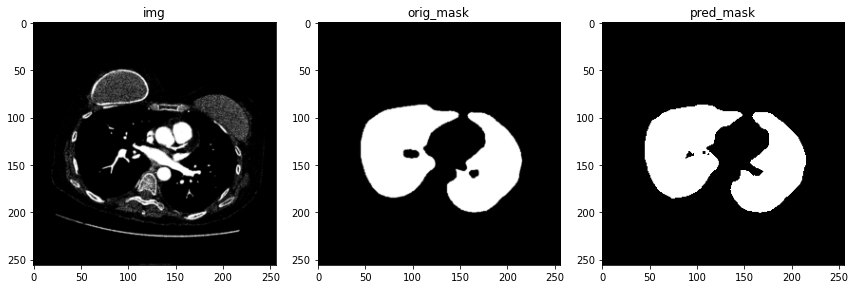

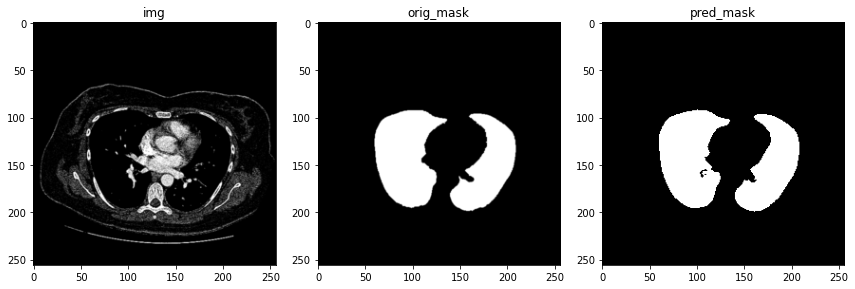

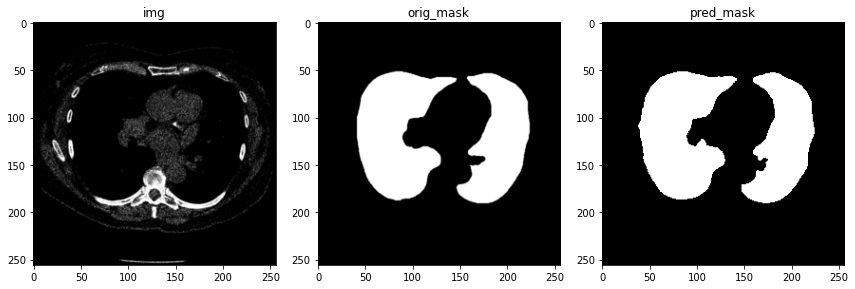

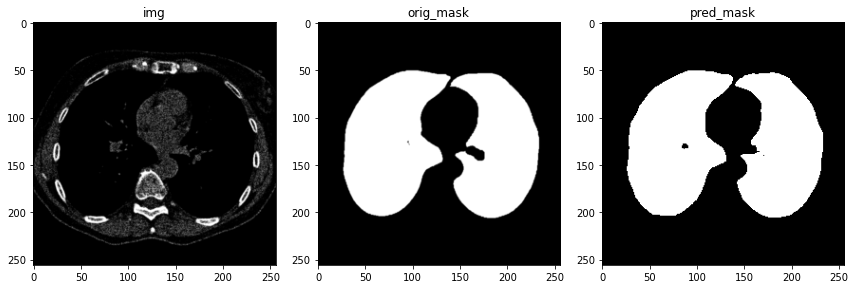

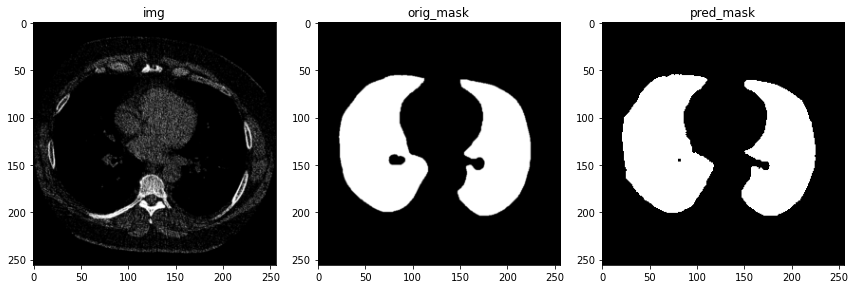

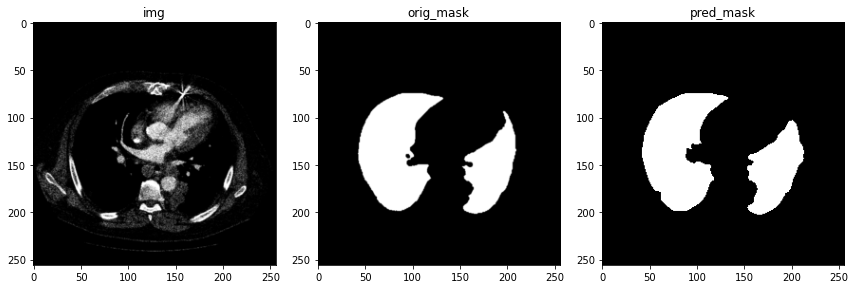

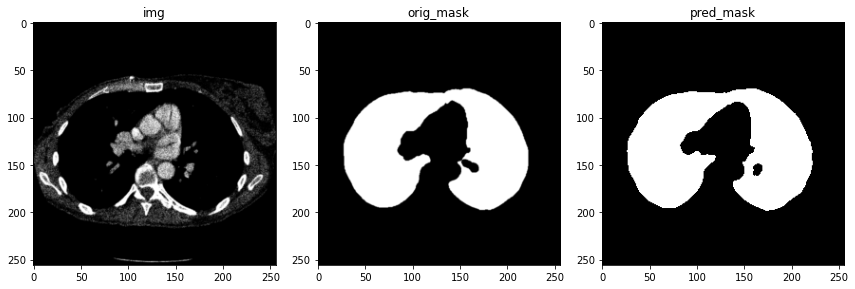

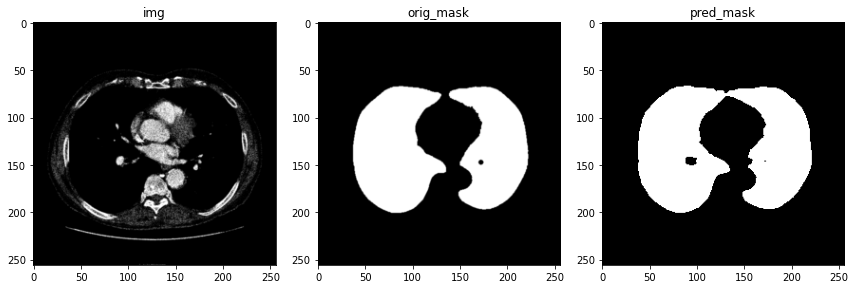

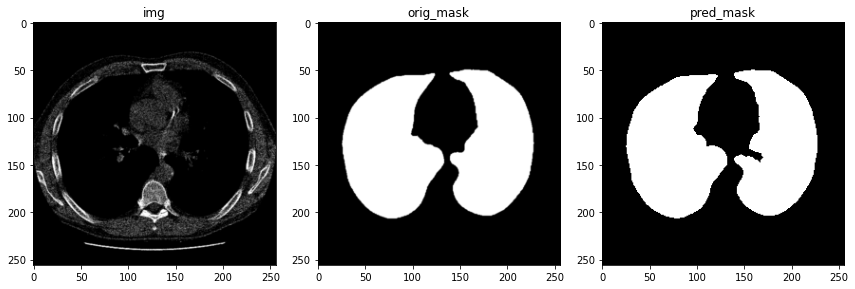

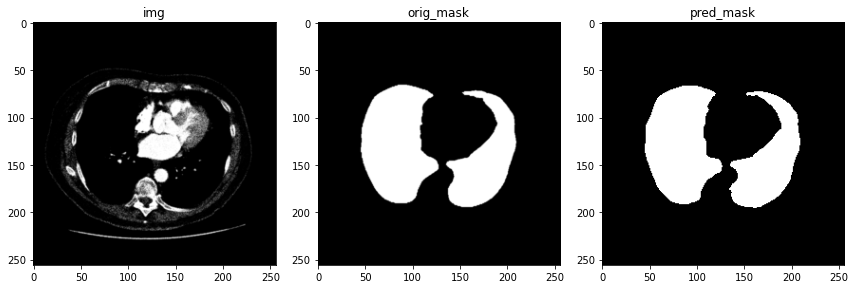

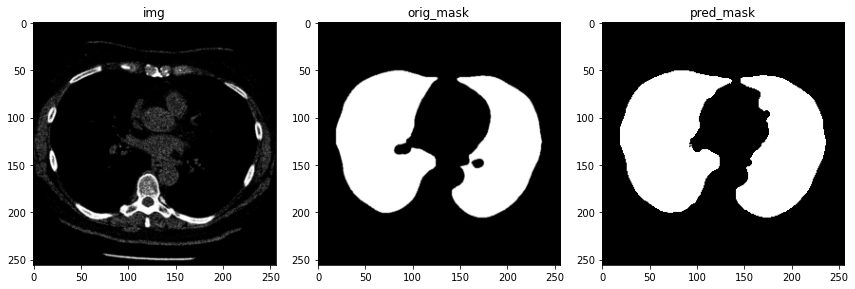

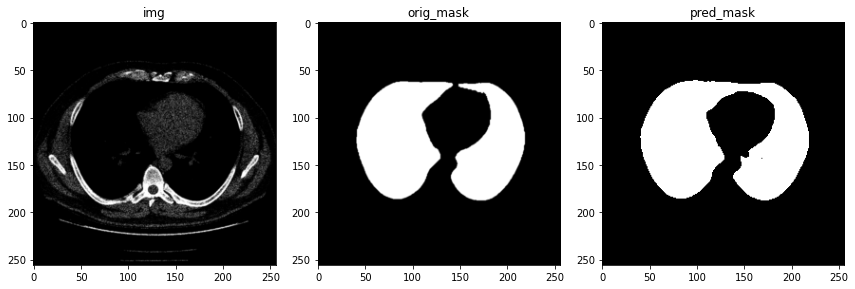

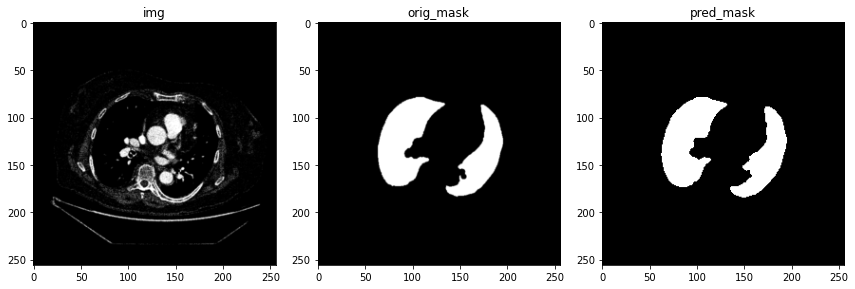

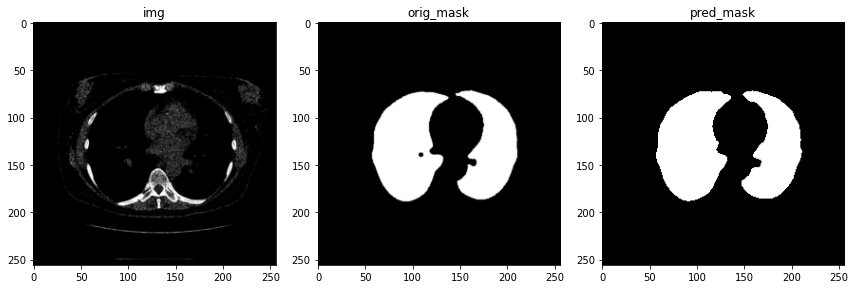

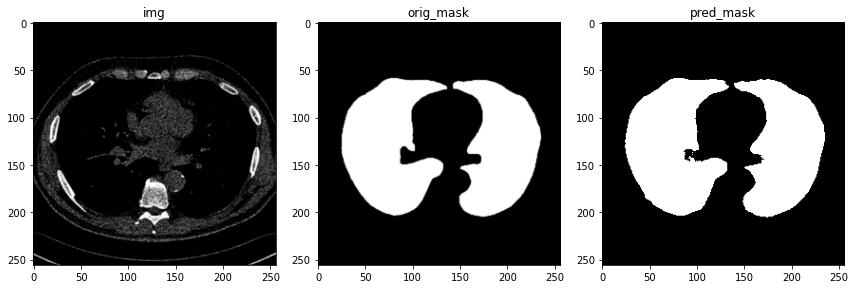

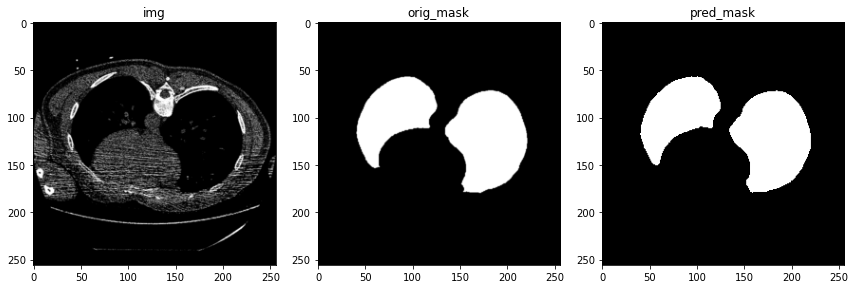

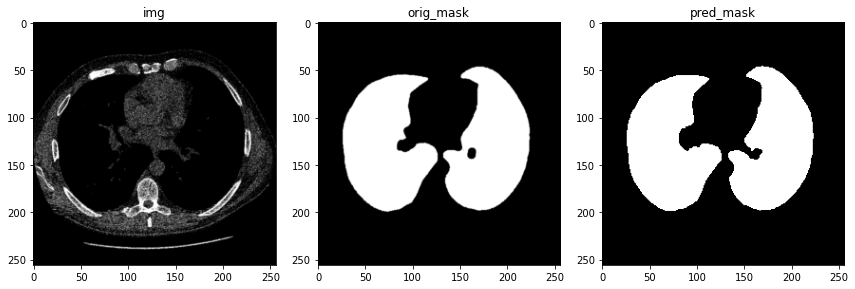

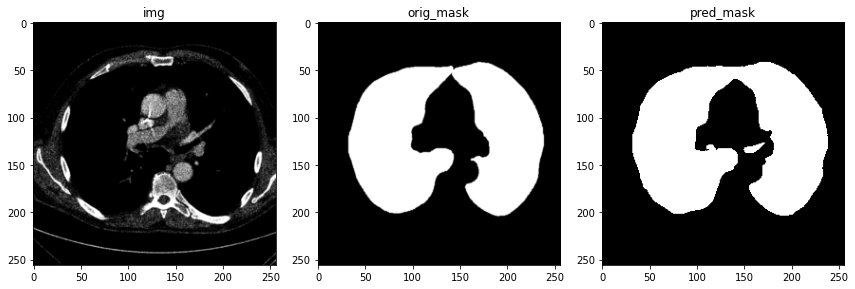

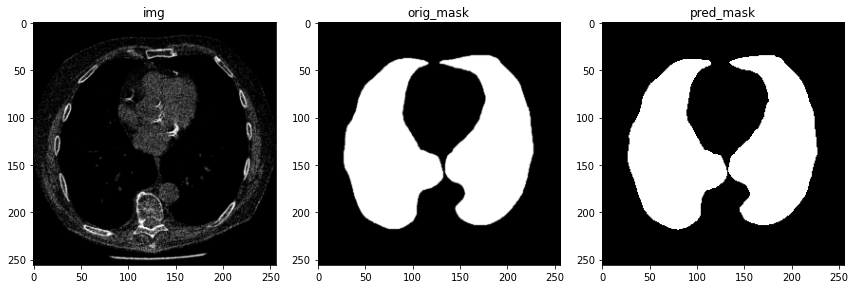

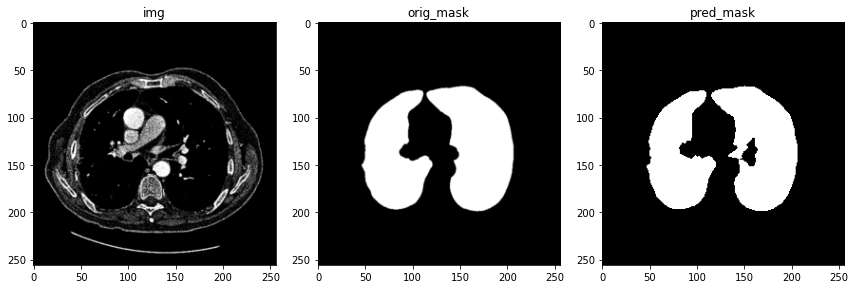

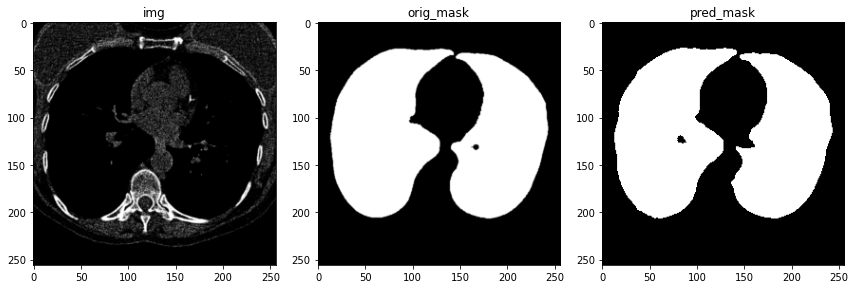

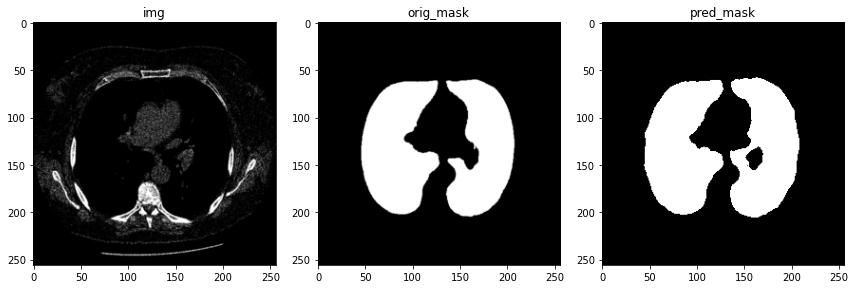

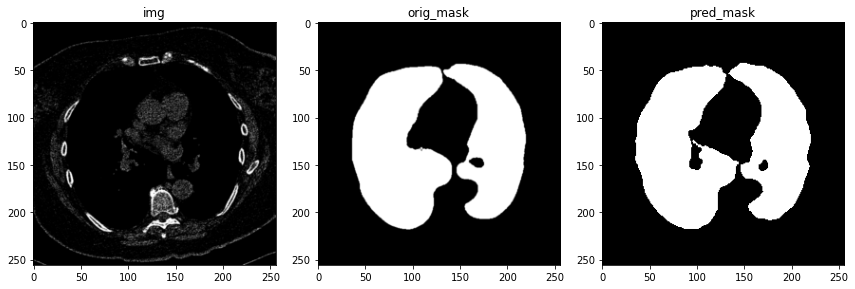

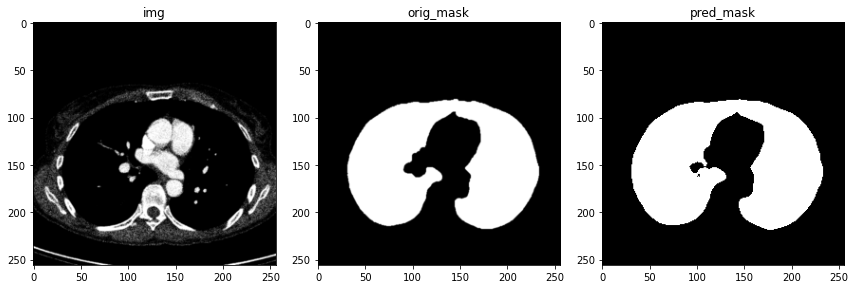

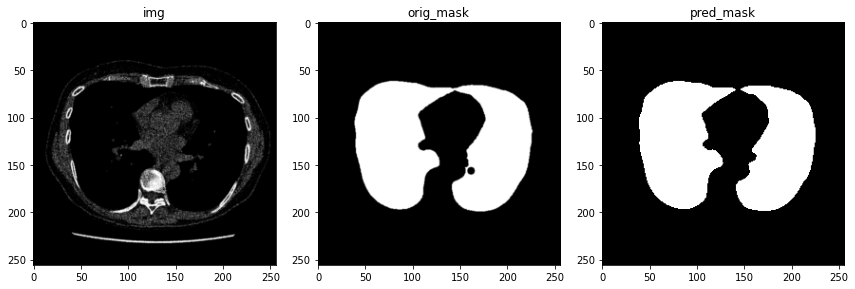

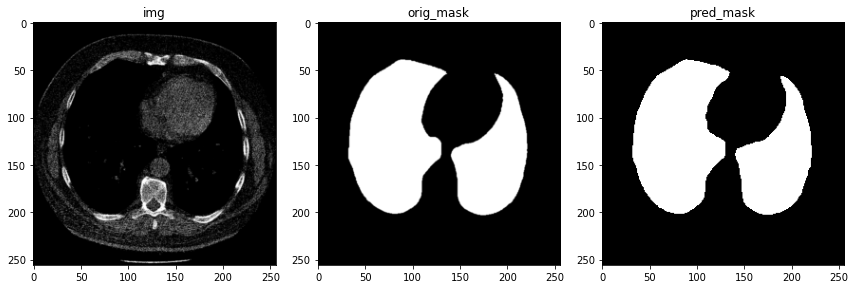

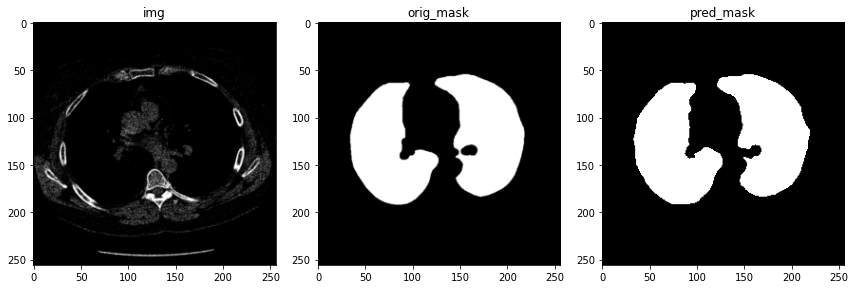

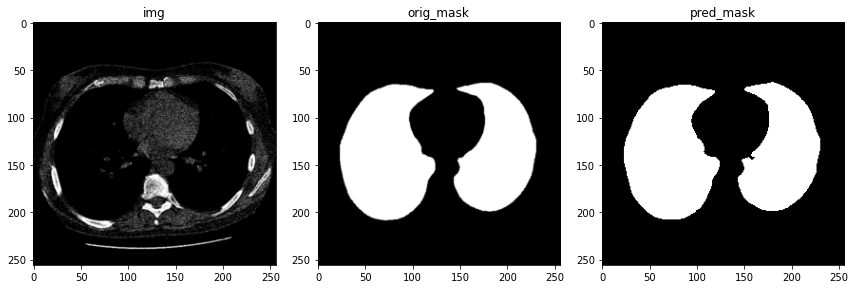

In [113]:
for img, mask in ds_test:
  pred_mask = predict_image(img, model)
  show_imgs(img, mask, pred_mask)